<a href="https://colab.research.google.com/github/NilanjanChattopadhyay/NilanjanChattopadhyay.github.io/blob/master/notebooks/Regularization_from_Scratch_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural networks containing multiple non-linear hidden layers are universal approximators capable of learning very complicated relationships between inputs and outputs. This makes them extremely flexible and very powerful machine learning systems as we saw on the last [post](https://nilanjanchattopadhyay.github.io/basics/2020/04/01/Deep-Learning-from-Scratch.html). But this flexibility can lead to overfitting, a common problem in neural networks. Large deep learning models often perform far better on training data than on validation data. 

Let's try to see that in practice. We will start by creating a synthetic data [like we did previously](https://nilanjanchattopadhyay.github.io/basics/2020/04/01/Deep-Learning-from-Scratch.html).



In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [0]:
# The parameters of neural networks are initialized at random
# By setting a seed we should get the same initial weights every time
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Here we are creating a *Input* data with 100 dimensions and 10,000 data points randomly generated from $ U(-1, 1] $. Let's denote the dimensions of the *Input* vectors as $ x_{0}, x_{1}, \dots x_{99} $.

In [0]:
Input = 2*torch.rand(10000, 100)-1

## Experiment 1 - High Dimensional Data with Extra Variables and Random Noise

We will create a *Target* vector from the input using the following relation:

$$ Target = f(x_{0}, x_{1}, \dots x_{99}) = x_{0}^{0} - x_{1} + x_{2}^{2} - x_{3} \dots  x_{46}^{46} - x_{47} + x_{48}^{48} - x_{49} + \epsilon $$
$$ \text{where } \epsilon \text{ is random noise} $$

There is no reason for choosing this particular relation between *Input* and *Target*. We are trying to create a high-dimensional regression problem with non-linear relationship between the *Input* and *Target* vectors. Though the *Input* has 100 dimensions/variables, note that the relation is dependent on only 50 variables. In practice we will always have extra variables and noise in our data.


In [0]:
Target = torch.zeros(10000)
for i in range(50):
  if i%2 == 0:
    Temp = Input[:, i].pow(i)
    Target += Temp
  else:
    Temp = Input[:, i]
    Target -= Temp

In [0]:
# Add Random Noise
Noise = 0.5*torch.randn_like(Target)
Target += Noise

In [7]:
print('-'*20, 'Output Cell', '-'*20, '\n')
#Target Dimension
print(Target.shape)

#Reshape the target variables to appropriate dimension
Target = Target.view(10000, 1)

#New Target Dimension
print(Target.shape)

-------------------- Output Cell -------------------- 

torch.Size([10000])
torch.Size([10000, 1])


We will use the first 5,000 elements for training our Neural Network and the remaining 5,000 elements for validation. Let's create the *DataLoader* using our *Input* and *Target*.

In [0]:
from torch.utils.data import TensorDataset, DataLoader

Train_Dataset = TensorDataset(Input[:5000], Target[:5000])
Validation_Dataset = TensorDataset(Input[5000:], Target[5000:])

batch_size = 1000
Train_DataLoader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)
Validation_DataLoader = DataLoader(Validation_Dataset, batch_size=batch_size*5)

The objective is to create a Neural Network that can identify this non-linear high dimensional relationship.

Let’s create a neural network with 2 Hidden Layers and 100 units in each hidden layer and training it for 1000 epochs. 

In [0]:
# Define Neural Network
class NeuralNetwork(torch.nn.Module):

  def __init__(self, Input_Size=100):
    super(NeuralNetwork, self).__init__()
    self.HiddenLayer_1 = torch.nn.Sequential(torch.nn.Linear(Input_Size, 100), torch.nn.ReLU())
    self.HiddenLayer_2 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.OutputLayer = torch.nn.Linear(100, 1)

  def forward(self, Input):
    Output = self.HiddenLayer_1(Input)
    Output = self.HiddenLayer_2(Output)
    Output = self.OutputLayer(Output)
    return Output

# Loss Function - Cross Entropy Loss
Loss_Function = torch.nn.MSELoss()

def Training(Model, Train_DataLoader, Validation_DataLoader, learning_rate = 0.01, epochs = 1000):
  
  print('-'*20, 'Output Cell', '-'*20, '\n')

  # Optimizer - Stochastic Gradient Descent
  Optimizer = torch.optim.SGD(Model.parameters(), lr=learning_rate)
  
  for epoch in range(epochs):
    Model.train()
    for X, Y in Train_DataLoader:
      
      # Forward Pass 
      Predicted = Model(X)

      # Compute Loss
      Loss = Loss_Function(Predicted, Y)

      # Backward Pass
      Loss.backward()
      Optimizer.step()
      Optimizer.zero_grad()

    # Calculate Validation Loss
    if epoch%100 == 0:
      Model.eval()
      with torch.no_grad():
        Validation_Loss = sum(Loss_Function(Model(X), Y) for X, Y in Validation_DataLoader)
        Validation_Loss = Validation_Loss/len(Validation_DataLoader)
      print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

  # Calulate Validation Loss
  Model.eval()
  with torch.no_grad():
    Validation_Loss = sum(Loss_Function(Model(X), Y) for X, Y in Validation_DataLoader)
    Validation_Loss = Validation_Loss/len(Validation_DataLoader)

  print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

Note that we put the training part of the code in a function. This will make experimentation easier. We just need to run 2 lines of code.

In [10]:
%%time

# Instantiate Model    
Model = NeuralNetwork(Input_Size=100)

# Train the Model
Training(Model, Train_DataLoader, Validation_DataLoader, learning_rate = 0.01, epochs = 1000)

-------------------- Output Cell -------------------- 

Epoch: 0. Train Loss: 14.482518196105957. Validation Loss: 13.808280944824219
Epoch: 100. Train Loss: 0.694995105266571. Validation Loss: 0.9867028594017029
Epoch: 200. Train Loss: 0.5789515376091003. Validation Loss: 0.9881474375724792
Epoch: 300. Train Loss: 0.39037877321243286. Validation Loss: 1.035902500152588
Epoch: 400. Train Loss: 0.2847561836242676. Validation Loss: 1.0960569381713867
Epoch: 500. Train Loss: 0.21917188167572021. Validation Loss: 1.1488596200942993
Epoch: 600. Train Loss: 0.1831873208284378. Validation Loss: 1.2025138139724731
Epoch: 700. Train Loss: 0.12253811210393906. Validation Loss: 1.2555932998657227
Epoch: 800. Train Loss: 0.09219234436750412. Validation Loss: 1.3032523393630981
Epoch: 900. Train Loss: 0.07254666090011597. Validation Loss: 1.34823739528656
Epoch: 999. Train Loss: 0.05652352049946785. Validation Loss: 1.3870981931686401
CPU times: user 1min, sys: 961 ms, total: 1min 1s
Wall time: 1mi

Let's breakdown the output into 2 key points -

1.   Our network was able to identify the non-linear high dimensional relationship between *Input* and *Output* for training data with *MSE* ~ 0.056.
2.   The *MSE* for validation dataset initially decreased to ~ 0.98 and then started to increase as we continued training never decreasing again.

This is a clear case of overfitting.

Our network overfitted on a data where the validation data is coming from the exact same distribution. One reason for overfitting could be that our model learnt relations that were not present using the variables that were not part of the relationship: $ x_{50}, x_{51}, \dots x_{99} $. Another reason could be that our model tried to learn the random noise present in our data.


Insert Diagram

## Experiment 2 - High Dimensional Data without Extra Variables or Random Noise

What if the we didn't have any noise in the data? And no extra variables? In practice this will be nearly impossible to achieve. But for the sake of experimentation let's do that anyway.

Let's recreate the target variable using the following:

$$ Target = f(x_{0}, x_{1}, \dots x_{99}) = x_{0}^{0} - x_{1} + x_{2}^{2} - x_{3} \dots  x_{96}^{96} - x_{97} + x_{98}^{98} - x_{99} $$

In [0]:
Target = torch.zeros(10000)
for i in range(100):
  if i%2 == 0:
    Temp = Input[:, i].pow(i)
    Target += Temp
  else:
    Temp = Input[:, i]
    Target -= Temp

#Reshape the target variables to appropriate dimension
Target = Target.view(10000, 1)

In [0]:
Train_Dataset = TensorDataset(Input[:5000], Target[:5000])
Validation_Dataset = TensorDataset(Input[5000:], Target[5000:])

batch_size = 1000
Train_DataLoader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)
Validation_DataLoader = DataLoader(Validation_Dataset, batch_size=batch_size*5)

In [13]:
%%time

# Instantiate Model    
Model = NeuralNetwork(Input_Size=100)

# Train the Model
Training(Model, Train_DataLoader, Validation_DataLoader, learning_rate = 0.01, epochs = 1000)

-------------------- Output Cell -------------------- 

Epoch: 0. Train Loss: 24.328731536865234. Validation Loss: 22.96080780029297
Epoch: 100. Train Loss: 0.633903980255127. Validation Loss: 0.9417136907577515
Epoch: 200. Train Loss: 0.4260443449020386. Validation Loss: 0.9200699329376221
Epoch: 300. Train Loss: 0.3237161636352539. Validation Loss: 0.9383423924446106
Epoch: 400. Train Loss: 0.22297456860542297. Validation Loss: 0.9710943102836609
Epoch: 500. Train Loss: 0.16448669135570526. Validation Loss: 1.010853886604309
Epoch: 600. Train Loss: 0.11311528086662292. Validation Loss: 1.045843243598938
Epoch: 700. Train Loss: 0.0968901664018631. Validation Loss: 1.0791065692901611
Epoch: 800. Train Loss: 0.07469366490840912. Validation Loss: 1.1124778985977173
Epoch: 900. Train Loss: 0.05325717478990555. Validation Loss: 1.1438113451004028
Epoch: 999. Train Loss: 0.04721399024128914. Validation Loss: 1.1725291013717651
CPU times: user 1min 3s, sys: 959 ms, total: 1min 3s
Wall time: 

Again let's breakdown the results into 2 key points -

*   Our network was able to identify the non-linear high dimensional relationship between Input and Output for training data with MSE ~ 0.04
*   The MSE for validation dataset initially decreased to ~ 0.92 and then started to increase as we continued training

Even in the absence of any statistical noise our model can overfit. As the dimension of the input increases, the flexibility of our model increases. Higher dimension size means more parameters which makes the model's function selection range is wider making it more prone to overfitting as there will be many different functions that can model the training set almost perfectly. 

Insert Diagram


There are various ways to address this problem of overfitting. We can reduce the input dimension or increase training data or use weight penalties of various
kinds such as $L1$ and $L2$ regularization. In this post we will be looking at one of the key techniques for reducing overfitting in neural networks - **Dropout**.

# **Dropout**

In 2014 by Srivastava et al. published a paper titled [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) revolutionizing the field of deep learning. In their [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), they introduced the idea of randomly dropping units from the neural network during training. They explained that dropout prevents overfitting and provides a way of combining different neural network architectures efficiently. 

Ensembling multiple models is good way to reduce overfitting and nearly always improves the performance. So, we can train large number of neural networks and average their predictions to get better results. However, this can be very challenging with bigger networks. Training a large is computationally expensive and training multiple models might not be feasible. Ensembling is generally more helpful when the models are not correlated i.e, they should be different from each other. To achieve that the neural networks would need to be of different architectures and trained on different data. This also can be very challenging as we will need to tune every architecture seperately. Also, there may not be enough data available to train different networks on
different subsets of the data.

Dropout is a technique that provides a way of combining many different neural network architectures efficiently. Dropout means randomly switching off some hidden units in a neural network while training. 

In [0]:
%%time
class NeuralNetwork(torch.nn.Module):

  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.HiddenLayer_1 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.HiddenLayer_2 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.OutputLayer = torch.nn.Linear(100, 1)

  def forward(self, Input):
    Output = self.HiddenLayer_1(Input)
    Output = self.HiddenLayer_2(Output)
    Output = self.OutputLayer(Output)
    return Output

# Instantiate Model    
Classifier = NeuralNetwork()

# Loss Function - Cross Entropy Loss
Loss_Function = torch.nn.MSELoss()

learning_rate = 0.01
epochs = 1000

# Optimizer - Stochastic Gradient Descent
Optimizer = torch.optim.SGD(Classifier.parameters(), lr=learning_rate)

for epoch in range(epochs):
  Classifier.train()
  for X, Y in Train_DataLoader:
    
    # Forward Pass 
    Predicted = Classifier(X)

    # Compute Loss
    Loss = Loss_Function(Predicted, Y)

    # Backward Pass
    Loss.backward()
    Optimizer.step()
    Optimizer.zero_grad()

  # Calculate Validation Loss
  if epoch%100 == 0:
    Classifier.eval()
    with torch.no_grad():
      Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
      Validation_Loss = Validation_Loss/len(Validation_DataLoader)
    print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

# Calulate Validation Loss
Classifier.eval()
with torch.no_grad():
  Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
  Validation_Loss = Validation_Loss/len(Validation_DataLoader)

print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

Epoch: 0. Train Loss: 3.723867177963257. Validation Loss: 3.915928602218628
Epoch: 100. Train Loss: 3.054016351699829. Validation Loss: 3.254258155822754
Epoch: 200. Train Loss: 1.5870224237442017. Validation Loss: 2.8110504150390625
Epoch: 300. Train Loss: 0.5086235404014587. Validation Loss: 2.453244209289551
Epoch: 400. Train Loss: 0.22593052685260773. Validation Loss: 2.3984580039978027
Epoch: 500. Train Loss: 0.14213888347148895. Validation Loss: 2.406480550765991
Epoch: 600. Train Loss: 0.087738536298275. Validation Loss: 2.436570882797241
Epoch: 700. Train Loss: 0.08831537514925003. Validation Loss: 2.4292030334472656
Epoch: 800. Train Loss: 0.08758869022130966. Validation Loss: 2.454561710357666
Epoch: 900. Train Loss: 0.0418587327003479. Validation Loss: 2.4281694889068604
Epoch: 999. Train Loss: 0.03452425077557564. Validation Loss: 2.46171236038208
CPU times: user 1min 1s, sys: 719 ms, total: 1min 2s
Wall time: 1min 2s


In [0]:
%%time
class NeuralNetwork(torch.nn.Module): bn m 

  def __init__(self, Dropout=0.5):
    super(NeuralNetwork, self).__init__()
    self.HiddenLayer_1 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.HiddenLayer_2 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.OutputLayer = torch.nn.Linear(100, 1)

    self.Dropout = Dropout

  def forward(self, Input):
    Output = self.HiddenLayer_1(Input)
    # Use dropout only when training the model
    if self.training:
      DropoutLayer = (torch.rand_like(Output, dtype=torch.float) > self.Dropout).float()
      Output = (Output*DropoutLayer)/(1-self.Dropout)
    Output = self.HiddenLayer_2(Output)
    # Use dropout only when training the model
    if self.training:
      DropoutLayer = (torch.rand_like(Output, dtype=torch.float) > self.Dropout).float()
      Output = (Output*DropoutLayer)/(1-self.Dropout)
    Output = self.OutputLayer(Output)
    return Output

# Instantiate Model    
Classifier = NeuralNetwork()

# Loss Function - Cross Entropy Loss
Loss_Function = torch.nn.MSELoss()

learning_rate = 0.01
epochs = 1000

# Optimizer - Stochastic Gradient Descent
Optimizer = torch.optim.SGD(Classifier.parameters(), lr=learning_rate)

for epoch in range(epochs):
  Classifier.train()
  for X, Y in Train_DataLoader:
    
    # Forward Pass 
    Predicted = Classifier(X)

    # Compute Loss
    Loss = Loss_Function(Predicted, Y)

    # Backward Pass
    Loss.backward()
    Optimizer.step()
    Optimizer.zero_grad()

  # Calculate Validation Loss
  if epoch%100 == 0:
    Classifier.eval()
    with torch.no_grad():
      Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
      Validation_Loss = Validation_Loss/len(Validation_DataLoader)
    print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

# Calulate Validation Loss
Classifier.eval()
with torch.no_grad():
  Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
  Validation_Loss = Validation_Loss/len(Validation_DataLoader)

print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

Epoch: 0. Train Loss: 4.232177734375. Validation Loss: 3.9791347980499268
Epoch: 100. Train Loss: 3.675645589828491. Validation Loss: 3.498324155807495
Epoch: 200. Train Loss: 2.9564197063446045. Validation Loss: 3.1979665756225586
Epoch: 300. Train Loss: 2.762871742248535. Validation Loss: 3.0747525691986084
Epoch: 400. Train Loss: 2.660318374633789. Validation Loss: 2.845076084136963
Epoch: 500. Train Loss: 2.182311534881592. Validation Loss: 2.570600986480713
Epoch: 600. Train Loss: 1.990820050239563. Validation Loss: 2.3535451889038086
Epoch: 700. Train Loss: 1.704591989517212. Validation Loss: 2.2071280479431152
Epoch: 800. Train Loss: 1.5383833646774292. Validation Loss: 2.116896629333496
Epoch: 900. Train Loss: 1.4893604516983032. Validation Loss: 2.0616343021392822
Epoch: 999. Train Loss: 1.3154215812683105. Validation Loss: 2.0234758853912354
CPU times: user 1min 16s, sys: 1.92 s, total: 1min 18s
Wall time: 1min 18s


In [0]:
%%time
class NeuralNetwork(torch.nn.Module):

  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.HiddenLayer_1 = torch.nn.Sequential(torch.nn.Linear(50, 100), torch.nn.ReLU(), torch.nn.Dropout())
    self.HiddenLayer_2 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU(), torch.nn.Dropout())
    self.OutputLayer = torch.nn.Linear(100, 1)

  def forward(self, Input):
    Output = self.HiddenLayer_1(Input)
    Output = self.HiddenLayer_2(Output)
    Output = self.OutputLayer(Output)
    return Output

# Instantiate Model    
Classifier = NeuralNetwork()

# Loss Function - Cross Entropy Loss
Loss_Function = torch.nn.MSELoss()

learning_rate = 0.01
epochs = 1000

# Optimizer - Stochastic Gradient Descent
Optimizer = torch.optim.SGD(Classifier.parameters(), lr=learning_rate)

for epoch in range(epochs):
  Classifier.train()
  for X, Y in Train_DataLoader:
    
    # Forward Pass 
    Predicted = Classifier(X)

    # Compute Loss
    Loss = Loss_Function(Predicted, Y)

    # Backward Pass
    Loss.backward()
    Optimizer.step()
    Optimizer.zero_grad()

  # Calculate Validation Loss
  if epoch%100 == 0:
    Classifier.eval()
    with torch.no_grad():
      Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
      Validation_Loss = Validation_Loss/len(Validation_DataLoader)
    print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

# Calulate Validation Loss
Classifier.eval()
with torch.no_grad():
  Validation_Loss = sum(Loss_Function(Classifier(X), Y) for X, Y in Validation_DataLoader)
  Validation_Loss = Validation_Loss/len(Validation_DataLoader)

print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

Epoch: 0. Train Loss: 12.016242027282715. Validation Loss: 12.773066520690918
Epoch: 100. Train Loss: 1.5205554962158203. Validation Loss: 0.7738429307937622
Epoch: 200. Train Loss: 1.2795571088790894. Validation Loss: 0.6890137791633606
Epoch: 300. Train Loss: 1.193935513496399. Validation Loss: 0.6626777648925781
Epoch: 400. Train Loss: 1.1249393224716187. Validation Loss: 0.6474982500076294
Epoch: 500. Train Loss: 1.0503013134002686. Validation Loss: 0.6376386284828186
Epoch: 600. Train Loss: 0.9359003901481628. Validation Loss: 0.6163305640220642
Epoch: 700. Train Loss: 0.8597337007522583. Validation Loss: 0.6056487560272217
Epoch: 800. Train Loss: 0.8781365156173706. Validation Loss: 0.5980207324028015
Epoch: 900. Train Loss: 0.8577926158905029. Validation Loss: 0.5923987030982971
Epoch: 999. Train Loss: 0.8847737908363342. Validation Loss: 0.5914652347564697
CPU times: user 1min 8s, sys: 1.68 s, total: 1min 9s
Wall time: 1min 10s


In [0]:
%%time
!wget http://pjreddie.com/media/files/cifar.tgz
!tar xzf cifar.tgz

--2020-04-12 10:00:52--  http://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/cifar.tgz [following]
--2020-04-12 10:00:52--  https://pjreddie.com/media/files/cifar.tgz
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz’

cifar.tgz           100%[===================>] 160.77M  5.04MB/s    in 38s     

2020-04-12 10:01:30 (4.21 MB/s) - ‘cifar.tgz’ saved [168584360/168584360]

CPU times: user 311 ms, sys: 70.5 ms, total: 381 ms
Wall time: 45.1 s


In [0]:
import os

print(os.getcwd())
print(os.listdir())
print(os.listdir('/content/cifar'))
print(os.listdir('/content/cifar/train')[:5])

/content
['.config', 'cifar', 'cifar.tgz', 'sample_data']
['labels.txt', 'train', 'test']
['23847_airplane.png', '21024_frog.png', '49971_truck.png', '44314_frog.png', '29980_airplane.png']


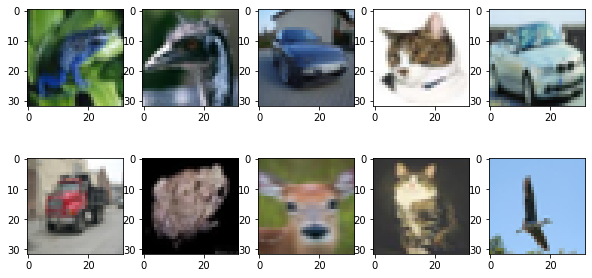

In [0]:
from PIL import Image

ImageList = [os.path.join('/content/cifar/train', x) for x in os.listdir('/content/cifar/train')]

fig=plt.figure(figsize=(10, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = ImageList[np.random.randint(len(ImageList))]
    img = Image.open(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
with open("/content/cifar/labels.txt") as label_file:
    labels = label_file.read().split()
    label_mapping = dict(zip(labels, list(range(len(labels)))))

In [0]:
class CIFAR_Dataset:

  def __init__(self, path):
    self.ImageList = [os.path.join(path, x) for x in os.listdir(path)]

  def __len__(self):
    return len(self.ImageList)

  def __getitem__(self, idx):
    location = self.ImageList[idx]
    image = Image.open(location)
    image = torch.tensor(np.array(image), dtype=torch.float)
    image = image.flatten()/255
    image = (image-0.5)/0.5
    label = location[:-4].split("_")[-1]
    label = label_mapping[label]
    return image, label

In [0]:
Train_Dataset = CIFAR_Dataset('/content/cifar/train')
Validation_Dataset = CIFAR_Dataset('/content/cifar/test')

In [0]:
from torch.utils.data import DataLoader

batch_size = 64
Train_DataLoader = DataLoader(Train_Dataset, batch_size=batch_size)
Validation_DataLoader = DataLoader(Validation_Dataset, batch_size=batch_size*2)

In [0]:
print(torch.cuda.is_available())
device = torch.device("cuda")

False


In [0]:
%%time
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.HiddenLayer1 = torch.nn.Sequential(torch.nn.Linear(3072, 100), torch.nn.ReLU())
    self.HiddenLayer2 = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU())
    self.OutputLayer = torch.nn.Sequential(torch.nn.Linear(100, 10))

  def forward(self, Input):
    Output = self.HiddenLayer1(Input)
    Output = self.HiddenLayer2(Output)
    Output = self.OutputLayer(Output)
    return Output

Model = NeuralNetwork()
Model.to(device)

Loss_Function = torch.nn.CrossEntropyLoss()

learning_rate = 0.01
epochs = 100

Optimizer = torch.optim.SGD(Model.parameters(), lr=learning_rate)

for epoch in range(epochs):
  Model.train()
  for X, Y in Train_DataLoader:
    X = X.to(device)
    Y = Y.to(device)

    # Forward Pass 
    Predicted = Model(X)

    # Compute Loss
    Loss = Loss_Function(Predicted, Y)

    # Backward Pass
    Loss.backward()
    Optimizer.step()
    Optimizer.zero_grad()

  # Calculate Validation Loss
  if epoch%10 == 0:
    Model.eval()
    with torch.no_grad():
      Validation_Loss = sum(Loss_Function(Model(X.to(device)), Y.to(device)) for X, Y in Validation_DataLoader)
      Validation_Loss = Validation_Loss/len(Validation_DataLoader)
    print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

# Calulate Validation Loss
Model.eval()
with torch.no_grad():
  Validation_Loss = sum(Loss_Function(Model(X.to(device)), Y.to(device)) for X, Y in Validation_DataLoader)
  Validation_Loss = Validation_Loss/len(Validation_DataLoader)

print('Epoch: {}. Train Loss: {}. Validation Loss: {}'.format(epoch, Loss, Validation_Loss))

RuntimeError: ignored

In [0]:
!nvidia-smi